In [35]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy import signal
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [36]:
# 读取数据
data_path = "./data/processed_data/ppg_signals.pkl"
df = pd.read_pickle(data_path)

In [37]:
sampling_rate = 500  # 采样率

In [38]:
df.head()

,file,start_idx,end_idx,signal_quality,ppg_segment
0,20250521001_2025-05-21 18_45_58_b.csv,0,5000,0,"[342619.0, 342553.0, 342553.0, 342553.0, 34255..."
1,20250521001_2025-05-21 18_45_58_b.csv,4000,9000,0,"[339318.0, 339318.0, 339318.0, 339318.0, 33931..."
2,20250521001_2025-05-21 18_45_58_b.csv,8000,13000,0,"[337009.0, 337009.0, 337009.0, 337009.0, 33697..."
3,20250521001_2025-05-21 18_48_11_b.csv,0,5000,0,"[335155.0, 335155.0, 335155.0, 335155.0, 33515..."
4,20250521001_2025-05-21 18_48_11_b.csv,4000,9000,0,"[329832.0, 329832.0, 329832.0, 329832.0, 32979..."


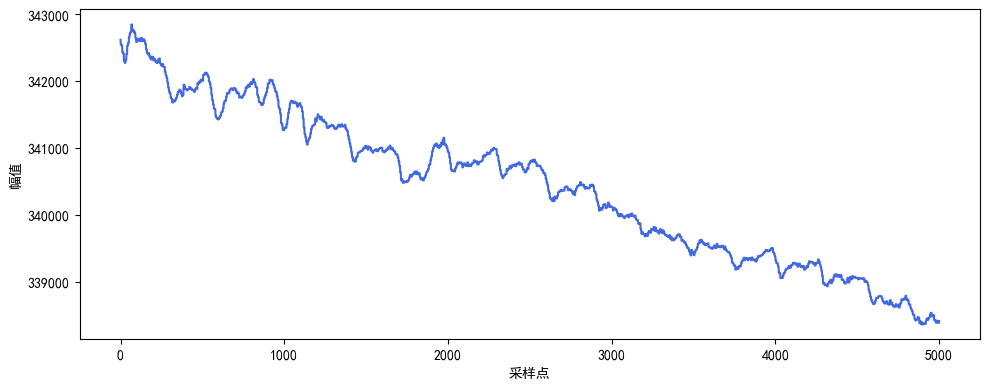

In [39]:
# 画出一段 ppg 信号
ppg = df.iloc[0]["ppg_segment"]

plt.figure(figsize=(10, 4))
plt.plot(ppg, color="royalblue")
plt.xlabel("采样点")
plt.ylabel("幅值")
plt.tight_layout()
plt.show()

In [40]:
# ppg去噪

from scipy.signal import butter, filtfilt


def normalize_signal(sig: np.ndarray) -> np.ndarray:
    """
    标准化信号，使其均值为0，标准差为1。

    Args:
        sig (np.ndarray): 输入信号

    Returns:
        np.ndarray: 标准化后的信号
    """
    return (sig - np.mean(sig)) / (np.std(sig) + 1e-8)


def bandpass_filter(
    sig: np.ndarray, fs: int, lowcut: float, highcut: float, order: int = 2
):
    """
    Apply a bandpass filter to the input signal.

    Args:
        sig (np.ndarray): The input signal.
        fs (int): The sampling frequency of the input signal.
        lowcut (float): The low cutoff frequency of the bandpass filter.
        highcut (float): The high cutoff frequency of the bandpass filter.

    Return:
        sig_filtered (np.ndarray): The filtered signal using a Butterworth bandpass filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    sig_filtered = filtfilt(b, a, sig)
    return sig_filtered

df['normalized_ppg'] = df["ppg_segment"].apply(lambda x: normalize_signal(x))
df["denoised_ppg"] = df["normalized_ppg"].apply(
    lambda x: bandpass_filter(x, fs=sampling_rate, lowcut=0.5, highcut=4)
)

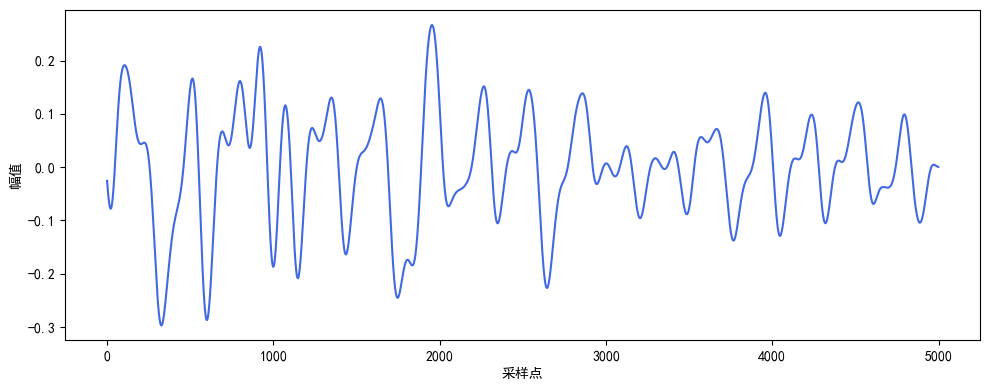

In [41]:
# 画出一段去噪后的 ppg 信号
ppg = df.iloc[0]["denoised_ppg"]

plt.figure(figsize=(10, 4))
plt.plot(ppg, color="royalblue")
plt.xlabel("采样点")
plt.ylabel("幅值")
plt.tight_layout()
plt.show()

In [42]:
# 参考：https://github.com/neuropsychology/NeuroKit
# 相关论文：
# Orphanidou, C. et al. (2015). "Signal-quality indices for the electrocardiogram and photoplethysmogram:
#     derivation and applications to wireless monitoring". IEEE Journal of Biomedical and Health Informatics, 19(3), 832-8.
# Sabeti E. et al. (2019). Signal quality measure for pulsatile physiological signals using morphological features:
#     Applications in reliability measure for pulse oximetry. Informatics in Medicine Unlocked, 16, 100222.


def find_peaks(ppg, sampling_rate, return_sig=False):
    ppg_cleaned = nk.ppg_clean(ppg, sampling_rate=sampling_rate)
    info = nk.ppg_findpeaks(ppg_cleaned, sampling_rate=sampling_rate, method="bishop")
    peaks = info["PPG_Peaks"]
    if return_sig:
        return peaks, ppg_cleaned
    else:
        return peaks, None


def normalize_data(sig):
    sig = np.array(sig)
    min_val = np.min(sig)
    max_val = np.max(sig)
    if max_val - min_val == 0:
        return np.zeros_like(sig)
    return (sig - min_val) / (max_val - min_val)


def heart_cycle_detection(ppg, sampling_rate):
    ppg_normalized = normalize_data(ppg)
    sampling_rate = sampling_rate * 2
    ppg_upsampled = signal.resample(ppg_normalized, len(ppg_normalized) * 2)
    peaks, ppg_cleaned = find_peaks(
        ppg=ppg_upsampled, sampling_rate=sampling_rate, return_sig=True
    )
    hc = []
    if len(peaks) < 2:
        return hc
    beat_bound = round((len(ppg_upsampled) / len(peaks)) / 2)
    for i in range(1, len(peaks) - 1):
        beat_start = peaks[i] - beat_bound
        beat_end = peaks[i] + beat_bound
        if beat_start >= 0 and beat_end < len(ppg_cleaned):
            beat = ppg_cleaned[beat_start:beat_end]
            if len(beat) >= beat_bound * 2:
                hc.append(beat)
    return hc


def template_matching_features(hc):
    hc = np.array([np.array(xi) for xi in hc if len(xi) != 0])
    template = np.mean(hc, axis=0)
    distances = []
    corrs = []
    for beat in hc:
        distances.append(np.linalg.norm(template - beat))
        corr_matrix = np.corrcoef(template, beat)
        corrs.append(corr_matrix[0, 1])
    tm_ave_eu = np.mean(distances)
    tm_ave_corr = np.mean(corrs)
    return tm_ave_eu, tm_ave_corr

In [ ]:
# 计算模板相似度
from joblib import Parallel, delayed

def calc_tm_features(row):
    hc = heart_cycle_detection(row["denoised_ppg"], sampling_rate)
    if len(hc) < 2:
        return {"tm_ave_eu": np.nan, "tm_ave_corr": np.nan}
    tm_ave_eu, tm_ave_corr = template_matching_features(hc)
    return {"tm_ave_eu": tm_ave_eu, "tm_ave_corr": tm_ave_corr}

results = Parallel(n_jobs=-1)(
    delayed(calc_tm_features)(row) for _, row in df.iterrows()
)
tm_df = pd.DataFrame(results)
df[["tm_ave_eu", "tm_ave_corr"]] = tm_df

In [ ]:
# 参考：https://github.com/neuropsychology/NeuroKit

def ppg_bassqi(ppg_signal: list, sampling_frequency: int) -> float:
    """
    计算PPG信号的基线漂移信号质量指数（basSQI），
    反映0-1Hz基线能量占0-40Hz总能量的比例（PPG主频一般不超过8Hz）。

    参数
    ----------
    ppg_signal : list or np.ndarray
        输入PPG信号
    sampling_frequency : int
        PPG采样率

    返回
    -------
    bas_sqi_score : float
        基线漂移信号质量分数，越接近1说明基线漂移越小
    """
    n = len(ppg_signal)
    t = 1 / sampling_frequency

    yf = np.fft.fft(ppg_signal)
    xf = np.linspace(0.0, 1.0 / (2.0 * t), n // 2)

    # 0-1Hz能量
    pds_num = [
        np.abs(yf[idx]) for idx in range(len(xf)) if xf[idx] >= 0 and xf[idx] <= 1
    ]
    # 0-40Hz能量
    pds_denom = [
        np.abs(yf[idx]) for idx in range(len(xf)) if xf[idx] >= 0 and xf[idx] <= 8
    ]

    if sum(pds_denom) == 0:
        return np.nan

    bas_sqi_score = float(np.round(1 - (sum(pds_num) / sum(pds_denom)), 3))
    return bas_sqi_score

# 应用于所有PPG信号
df["bassqi"] = df["denoised_ppg"].apply(lambda x: ppg_bassqi(x, sampling_rate))

In [ ]:
# 计算相关系数矩阵
corr_coef = df[["bassqi", "tm_ave_corr", "signal_quality"]].corr()
print(corr_coef)

                  bassqi  tm_ave_corr  signal_quality
bassqi          1.000000     0.551769        0.420865
tm_ave_corr     0.551769     1.000000        0.479188
signal_quality  0.420865     0.479188        1.000000


最佳阈值: tm_ave_corr > 0.935, bassqi > 0.414
最大准确率: 0.787


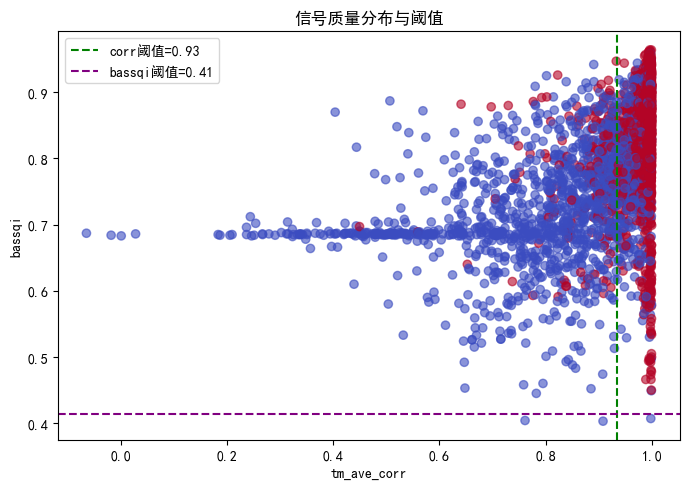

In [ ]:
# 寻找 tm_ave_corr 和 bassqi 的阈值用于判断 signal_quality

import numpy as np

# 设定阈值范围
corr_thresholds = np.linspace(df["tm_ave_corr"].min(), df["tm_ave_corr"].max(), 50)
bassqi_thresholds = np.linspace(df["bassqi"].min(), df["bassqi"].max(), 50)

best_acc = 0
best_corr_th = None
best_bassqi_th = None

# 判定高质量应为 bassqi > 阈值
for corr_th in corr_thresholds:
    for bassqi_th in bassqi_thresholds:
        pred = ((df["tm_ave_corr"] > corr_th) & (df["bassqi"] > bassqi_th)).astype(int)
        # 实际标签
        true = (df["signal_quality"] > 0.5).astype(int)
        # 计算准确率
        acc = (pred == true).mean()
        if acc > best_acc:
            best_acc = acc
            best_corr_th = corr_th
            best_bassqi_th = bassqi_th

print(f"最佳阈值: tm_ave_corr > {best_corr_th:.3f}, bassqi > {best_bassqi_th:.3f}")
print(f"最大准确率: {best_acc:.3f}")

# 可视化分布
plt.figure(figsize=(7,5))
plt.scatter(df["tm_ave_corr"], df["bassqi"], c=(df["signal_quality"] > 0.5), cmap="coolwarm", alpha=0.6)
plt.axvline(best_corr_th, color="green", linestyle="--", label=f"corr阈值={best_corr_th:.2f}")
plt.axhline(best_bassqi_th, color="purple", linestyle="--", label=f"bassqi阈值={best_bassqi_th:.2f}")
plt.xlabel("tm_ave_corr")
plt.ylabel("bassqi")
plt.legend()
plt.title("信号质量分布与阈值")
plt.tight_layout()
plt.show()

In [ ]:
df.to_pickle("./data/processed_data/ppg_signals_with_tm.pkl")